In [34]:
import numpy as np
import json
import csv
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import lightgbm as lgb
from sklearn import svm
import xgboost as xgb
import optuna

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [35]:
def load_data(y):
    path = '../../data/std_data/'
    x_train_std = pd.read_pickle(path +'train/{}_x.pkl'.format(str(y))).values
    x_test_std = pd.read_pickle(path +'test/{}_x.pkl'.format(str(y))).values
    y_train = pd.read_pickle(path +'train/{}_y.pkl'.format(str(y))).values
    y_test = pd.read_pickle(path +'test/{}_y.pkl'.format(str(y))).values
    features = pd.read_pickle(path +'train/{}_x.pkl'.format(str(y))).columns
    return x_train_std, x_test_std, y_train, y_test, features

In [36]:
def plot_roc_curve(fpr, tpr, auc):
    # ROC曲線をプロット
    plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()

In [43]:
def train(trial):
    
#     w_lr = trial.suggest_discrete_uniform('w_lr', 0, 1, 0.1)
    w_lda = trial.suggest_discrete_uniform('w_lda', 0, 1, 0.1)
    w_sv = trial.suggest_discrete_uniform('w_sv', 0, 1, 0.1)
    w_xgb = trial.suggest_discrete_uniform('w_xgb', 0, 1, 0.1)
    w_lgbm = trial.suggest_discrete_uniform('w_lgbm', 0, 1, 0.1)
    
    # 予測した確率全体を格納
    probs_all_lr = np.array([])
    probs_all_lda = np.array([])
    probs_all_sv = np.array([])
    probs_all_lgbm = np.array([])
    probs_all_xgb = np.array([])
    probs_all = np.array([])
    
    y_true_all = np.array([])
    cm_all = np.zeros((2, 2))
    
    for y in range(1978, 2020):
        
        # データの生成
        x_train_std, x_test_std, y_train, y_test, features = load_data(y)
        y_true_all = np.hstack((y_true_all, y_test))
       
        # logistic regression
#         lr = LogisticRegression(class_weight="balanced", solver="liblinear",  penalty="l2", C=0.0001) # ロジスティック回帰モデルのインスタンスを作成
#         lr.fit(x_train_std, y_train) # ロジスティック回帰モデルの重みを学習
#         probs_lr = lr.predict_proba(x_test_std)
#         probs_all_lr = np.hstack((probs_all_lr, probs_lr[:,1]))
        
        # LDA
        lda = LDA(solver="eigen", shrinkage=1).fit(x_train_std,  y_train)
        probs_lda = lda.predict_proba(x_test_std)
        probs_all_lda = np.hstack((probs_all_lda, probs_lda[:,1]))
        
        # svm
        sv = svm.SVR(kernel="sigmoid",
                                     degree=4,
                                     gamma=0.043502212815589775,
                                     coef0=0.20190829020616494,
                                     tol=0.0001,
                                     C=0.000245786293391316,
                                     epsilon=0.3056167642389302,
                                    verbose=False,)
        sv.fit(x_train_std, y_train)
        probs_sv = sv.predict(x_test_std)
        probs_all_sv = np.hstack((probs_all_sv, probs_sv))
        
        # xgb
        xgboost = xgb.XGBRegressor(silent= True, 
                               max_depth=4,
                               learning_rate=0.12765177534095626,
                               n_estimators = 46,
                               gamma=0.060805284848630535,
                               reg_lambda=4.995675788308118,
                               reg_alpha=2.1912254426545754,
                               sub_sample=0.45297631180790854,
                               scale_pos_weight=1.1672978934986058)
        xgboost.fit(x_train_std, y_train)
        probs_xgb = xgboost.predict(x_test_std)
        probs_all_xgb = np.hstack((probs_all_xgb, probs_xgb))
        
        
        
        # lgbm
        lgbm = lgb.LGBMRegressor(
            random_state=0,
            verbosity=-1,
            bagging_seed=0,
            boost_from_average='true',
            metric='auc',
            bagging_freq=4,
            min_data_in_leaf=21,
            max_depth=13,
            learning_rate=0.08731913651405197,
            n_estimators=3394,
            subsample=0.7054763057027115,
            num_leaves=438,
            reg_lambda=0.9377125325944119,  
        )
        
        lgbm.fit(x_train_std, y_train)
        probs_lgbm = lgbm.predict(x_test_std)
        probs_all_lgbm = np.hstack((probs_all_lgbm, probs_lgbm))


        
#         probs = w_lda * probs_lda[:,1] + w_lr * probs_lr[:,1] + w_sv * probs_sv + w_xgb * probs_xgb + w_lgbm * probs_lgbm
        probs = w_lda * probs_lda[:,1] + w_sv * probs_sv + w_xgb * probs_xgb + w_lgbm * probs_lgbm
        
        
        probs_all = np.hstack((probs_all, probs))
#         print(probs)

        # 混同行列
        y_pred = np.where((probs ==  max(probs)), 1, 0) #確率→0/1
        cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
        cm_all += cm
    
    
#     auc_lr = roc_auc_score(y_true_all, probs_all_lr)
    auc_lda = roc_auc_score(y_true_all, probs_all_lda)
    auc_sv = roc_auc_score(y_true_all, probs_all_sv)
    auc_xgb = roc_auc_score(y_true_all, probs_all_xgb)
    auc_lgbm = roc_auc_score(y_true_all, probs_all_lgbm)

    auc = roc_auc_score(y_true_all, probs_all)
    
    fpr, tpr, thresholds = roc_curve(y_true_all, probs_all)
    
    plot_roc_curve(fpr, tpr, auc)
    
    print("len: {0} , {1}".format(len(y_true_all), len(probs_all) ))
    print("confusion_matrix: ")
    print(cm_all)
#     print("AUC LR: ",auc_lr)
    print("AUC LDA: ",auc_lda)
    print("AUC svm: ",auc_sv)
    print("AUC xgb: ",auc_xgb)
    print("AUC lgbm: ", auc_lgbm)
    print("AUC all: ",auc)
    print()
    return -auc

In [44]:
def main():
    np.set_printoptions(precision=3, suppress=True)
    study = optuna.create_study()
    study.optimize(train, n_trials=100)
    print(study.best_trial)

[W 2019-08-22 18:03:09,977] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:03:09,982] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:03:09,986] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:03:09,989] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


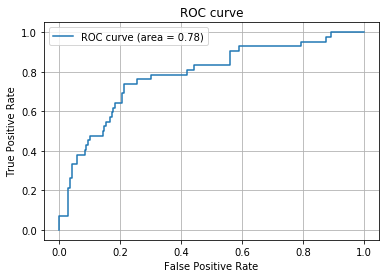

len: 211 , 211
confusion_matrix: 
[[150.  19.]
 [ 19.  23.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7833192448577063



[I 2019-08-22 18:03:43,553] Finished trial#0 resulted in value: -0.7833192448577063. Current best value is -0.7833192448577063 with parameters: {'w_lda': 0.1, 'w_sv': 0.9, 'w_xgb': 0.4, 'w_lgbm': 0.1}.
[W 2019-08-22 18:03:43,557] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:03:43,561] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:03:43,566] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:03:43,570] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


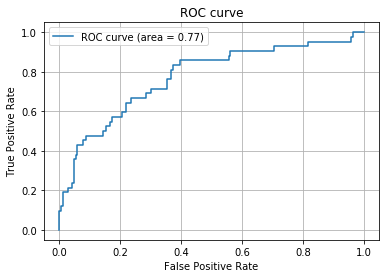

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7723302338686953



[I 2019-08-22 18:04:16,982] Finished trial#1 resulted in value: -0.7723302338686953. Current best value is -0.7833192448577063 with parameters: {'w_lda': 0.1, 'w_sv': 0.9, 'w_xgb': 0.4, 'w_lgbm': 0.1}.
[W 2019-08-22 18:04:16,986] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:04:16,989] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:04:16,995] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:04:16,999] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


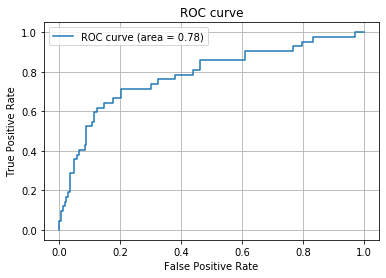

len: 211 , 211
confusion_matrix: 
[[150.  19.]
 [ 19.  23.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7837418991265145



[I 2019-08-22 18:04:49,963] Finished trial#2 resulted in value: -0.7837418991265145. Current best value is -0.7837418991265145 with parameters: {'w_lda': 0.7000000000000001, 'w_sv': 0.7000000000000001, 'w_xgb': 0.6000000000000001, 'w_lgbm': 0.6000000000000001}.
[W 2019-08-22 18:04:49,968] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:04:49,972] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:04:49,976] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:04:49,980] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


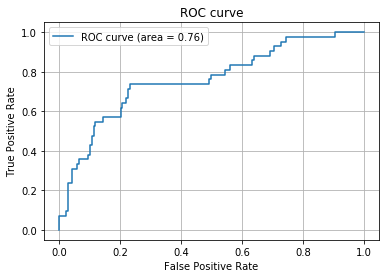

len: 211 , 211
confusion_matrix: 
[[150.  19.]
 [ 19.  23.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7596506058044519



[I 2019-08-22 18:05:23,282] Finished trial#3 resulted in value: -0.7596506058044519. Current best value is -0.7837418991265145 with parameters: {'w_lda': 0.7000000000000001, 'w_sv': 0.7000000000000001, 'w_xgb': 0.6000000000000001, 'w_lgbm': 0.6000000000000001}.
[W 2019-08-22 18:05:23,287] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:05:23,292] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:05:23,296] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:05:23,301] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


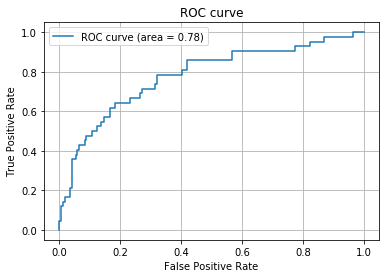

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7790927021696252



[I 2019-08-22 18:05:57,745] Finished trial#4 resulted in value: -0.7790927021696252. Current best value is -0.7837418991265145 with parameters: {'w_lda': 0.7000000000000001, 'w_sv': 0.7000000000000001, 'w_xgb': 0.6000000000000001, 'w_lgbm': 0.6000000000000001}.
[W 2019-08-22 18:05:57,749] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:05:57,754] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:05:57,758] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:05:57,763] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


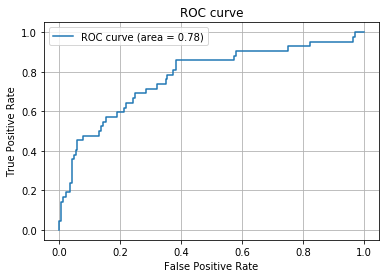

len: 211 , 211
confusion_matrix: 
[[150.  19.]
 [ 19.  23.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7757114680191602



[I 2019-08-22 18:06:31,691] Finished trial#5 resulted in value: -0.7757114680191602. Current best value is -0.7837418991265145 with parameters: {'w_lda': 0.7000000000000001, 'w_sv': 0.7000000000000001, 'w_xgb': 0.6000000000000001, 'w_lgbm': 0.6000000000000001}.
[W 2019-08-22 18:06:31,695] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:06:31,700] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:06:31,705] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:06:31,710] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


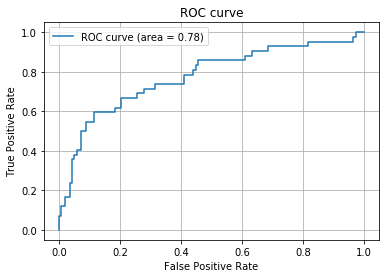

len: 211 , 211
confusion_matrix: 
[[148.  21.]
 [ 21.  21.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7754296985066216



[I 2019-08-22 18:07:05,543] Finished trial#6 resulted in value: -0.7754296985066216. Current best value is -0.7837418991265145 with parameters: {'w_lda': 0.7000000000000001, 'w_sv': 0.7000000000000001, 'w_xgb': 0.6000000000000001, 'w_lgbm': 0.6000000000000001}.
[W 2019-08-22 18:07:05,547] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:07:05,552] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:07:05,557] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:07:05,562] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


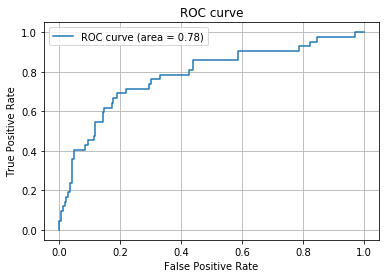

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7826148210763595



[I 2019-08-22 18:07:38,723] Finished trial#7 resulted in value: -0.7826148210763595. Current best value is -0.7837418991265145 with parameters: {'w_lda': 0.7000000000000001, 'w_sv': 0.7000000000000001, 'w_xgb': 0.6000000000000001, 'w_lgbm': 0.6000000000000001}.
[W 2019-08-22 18:07:38,728] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:07:38,733] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:07:38,738] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:07:38,744] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


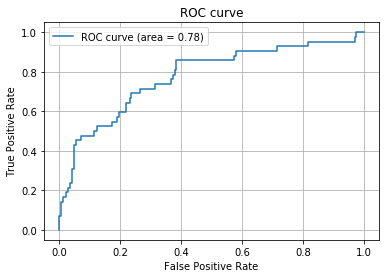

len: 211 , 211
confusion_matrix: 
[[150.  19.]
 [ 19.  23.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7761341222879685



[I 2019-08-22 18:08:11,813] Finished trial#8 resulted in value: -0.7761341222879685. Current best value is -0.7837418991265145 with parameters: {'w_lda': 0.7000000000000001, 'w_sv': 0.7000000000000001, 'w_xgb': 0.6000000000000001, 'w_lgbm': 0.6000000000000001}.
[W 2019-08-22 18:08:11,816] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:08:11,821] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:08:11,826] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:08:11,831] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


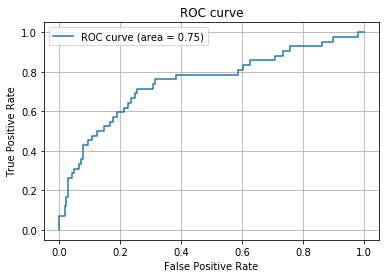

len: 211 , 211
confusion_matrix: 
[[150.  19.]
 [ 19.  23.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7473936320090165



[I 2019-08-22 18:08:45,759] Finished trial#9 resulted in value: -0.7473936320090165. Current best value is -0.7837418991265145 with parameters: {'w_lda': 0.7000000000000001, 'w_sv': 0.7000000000000001, 'w_xgb': 0.6000000000000001, 'w_lgbm': 0.6000000000000001}.
[W 2019-08-22 18:08:45,763] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:08:45,774] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:08:45,785] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:08:45,797] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


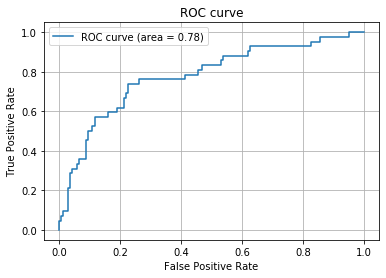

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7779656241194703



[I 2019-08-22 18:09:19,193] Finished trial#10 resulted in value: -0.7779656241194703. Current best value is -0.7837418991265145 with parameters: {'w_lda': 0.7000000000000001, 'w_sv': 0.7000000000000001, 'w_xgb': 0.6000000000000001, 'w_lgbm': 0.6000000000000001}.
[W 2019-08-22 18:09:19,198] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:09:19,209] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:09:19,219] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:09:19,230] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


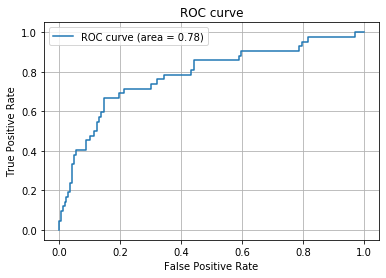

len: 211 , 211
confusion_matrix: 
[[148.  21.]
 [ 21.  21.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7837418991265146



[I 2019-08-22 18:09:52,430] Finished trial#11 resulted in value: -0.7837418991265146. Current best value is -0.7837418991265146 with parameters: {'w_lda': 0.4, 'w_sv': 0.9, 'w_xgb': 0.6000000000000001, 'w_lgbm': 0.6000000000000001}.
[W 2019-08-22 18:09:52,434] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:09:52,445] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:09:52,457] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:09:52,468] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


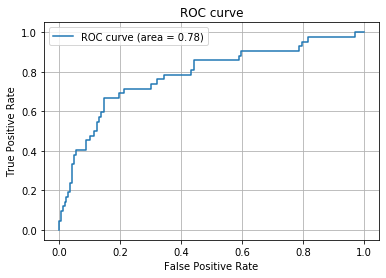

len: 211 , 211
confusion_matrix: 
[[148.  21.]
 [ 21.  21.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7837418991265146



[I 2019-08-22 18:10:25,469] Finished trial#12 resulted in value: -0.7837418991265146. Current best value is -0.7837418991265146 with parameters: {'w_lda': 0.4, 'w_sv': 0.9, 'w_xgb': 0.6000000000000001, 'w_lgbm': 0.6000000000000001}.
[W 2019-08-22 18:10:25,474] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:10:25,486] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:10:25,498] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:10:25,509] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


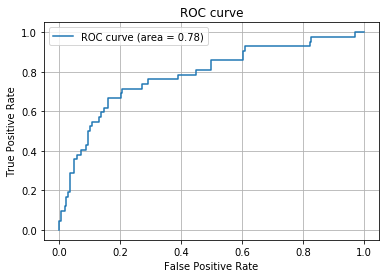

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7838827838827839



[I 2019-08-22 18:10:58,918] Finished trial#13 resulted in value: -0.7838827838827839. Current best value is -0.7838827838827839 with parameters: {'w_lda': 0.4, 'w_sv': 0.9, 'w_xgb': 0.6000000000000001, 'w_lgbm': 0.4}.
[W 2019-08-22 18:10:58,921] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:10:58,931] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:10:58,945] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:10:58,956] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


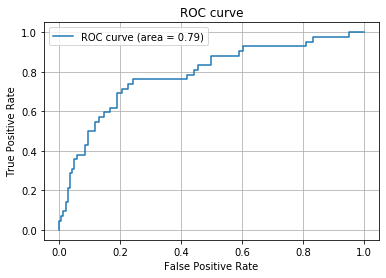

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7872640180332489



[I 2019-08-22 18:11:32,170] Finished trial#14 resulted in value: -0.7872640180332489. Current best value is -0.7872640180332489 with parameters: {'w_lda': 0.4, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:11:32,174] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:11:32,185] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:11:32,197] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:11:32,208] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


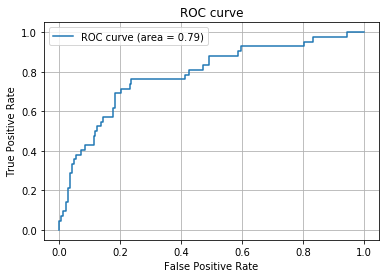

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7861369399830939



[I 2019-08-22 18:12:05,532] Finished trial#15 resulted in value: -0.7861369399830939. Current best value is -0.7872640180332489 with parameters: {'w_lda': 0.4, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:12:05,536] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:12:05,548] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:12:05,561] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:12:05,574] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


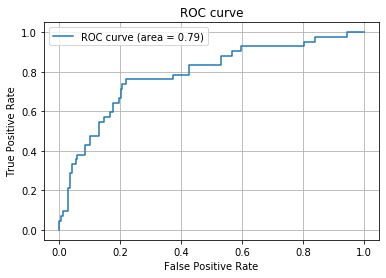

len: 211 , 211
confusion_matrix: 
[[150.  19.]
 [ 19.  23.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.786559594251902



[I 2019-08-22 18:12:38,768] Finished trial#16 resulted in value: -0.786559594251902. Current best value is -0.7872640180332489 with parameters: {'w_lda': 0.4, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:12:38,771] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:12:38,785] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:12:38,799] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:12:38,812] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


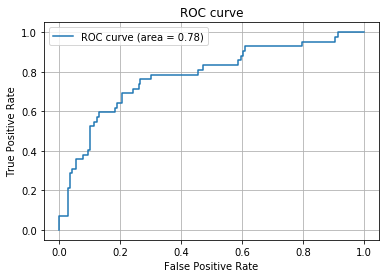

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7790927021696252



[I 2019-08-22 18:13:12,647] Finished trial#17 resulted in value: -0.7790927021696252. Current best value is -0.7872640180332489 with parameters: {'w_lda': 0.4, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:13:12,651] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:13:12,664] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:13:12,676] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:13:12,690] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


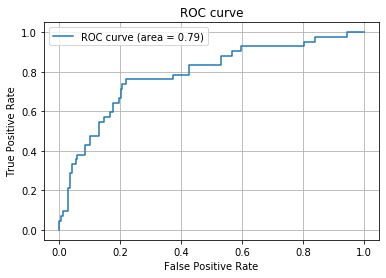

len: 211 , 211
confusion_matrix: 
[[150.  19.]
 [ 19.  23.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.786559594251902



[I 2019-08-22 18:13:46,655] Finished trial#18 resulted in value: -0.786559594251902. Current best value is -0.7872640180332489 with parameters: {'w_lda': 0.4, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:13:46,658] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:13:46,671] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:13:46,685] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:13:46,701] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


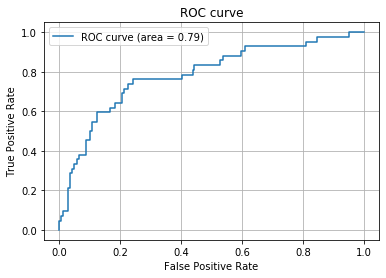

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7851507466892083



[I 2019-08-22 18:14:19,804] Finished trial#19 resulted in value: -0.7851507466892083. Current best value is -0.7872640180332489 with parameters: {'w_lda': 0.4, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:14:19,808] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:14:19,821] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:14:19,834] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:14:19,847] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


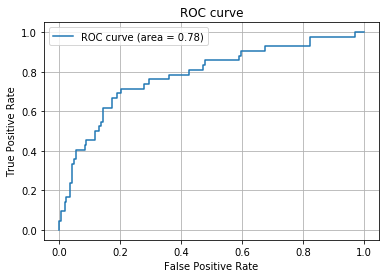

len: 211 , 211
confusion_matrix: 
[[148.  21.]
 [ 21.  21.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7827557058326288



[I 2019-08-22 18:14:52,898] Finished trial#20 resulted in value: -0.7827557058326288. Current best value is -0.7872640180332489 with parameters: {'w_lda': 0.4, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:14:52,902] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:14:52,916] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:14:52,928] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:14:52,942] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


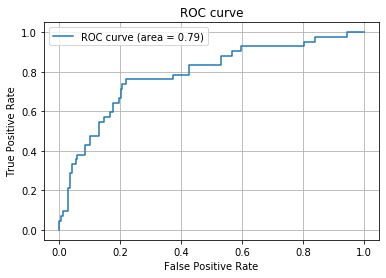

len: 211 , 211
confusion_matrix: 
[[150.  19.]
 [ 19.  23.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.786559594251902



[I 2019-08-22 18:15:26,112] Finished trial#21 resulted in value: -0.786559594251902. Current best value is -0.7872640180332489 with parameters: {'w_lda': 0.4, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:15:26,116] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:15:26,129] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:15:26,142] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:15:26,156] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


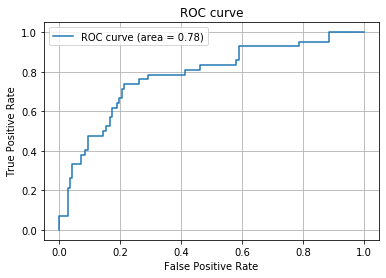

len: 211 , 211
confusion_matrix: 
[[150.  19.]
 [ 19.  23.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7807833192448577



[I 2019-08-22 18:15:59,511] Finished trial#22 resulted in value: -0.7807833192448577. Current best value is -0.7872640180332489 with parameters: {'w_lda': 0.4, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:15:59,516] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:15:59,530] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:15:59,543] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:15:59,559] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


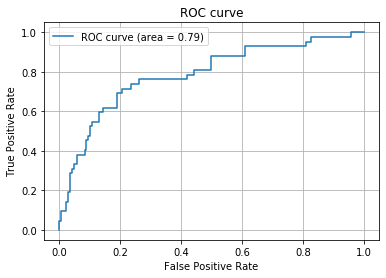

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7862778247393633



[I 2019-08-22 18:16:32,651] Finished trial#23 resulted in value: -0.7862778247393633. Current best value is -0.7872640180332489 with parameters: {'w_lda': 0.4, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:16:32,655] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:16:32,669] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:16:32,683] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:16:32,698] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


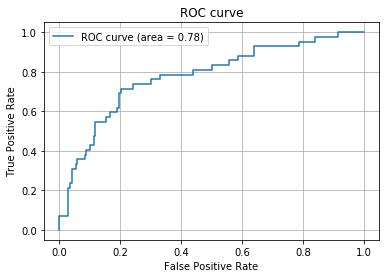

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.776697661313046



[I 2019-08-22 18:17:06,348] Finished trial#24 resulted in value: -0.776697661313046. Current best value is -0.7872640180332489 with parameters: {'w_lda': 0.4, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:17:06,352] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:17:06,366] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:17:06,380] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:17:06,394] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


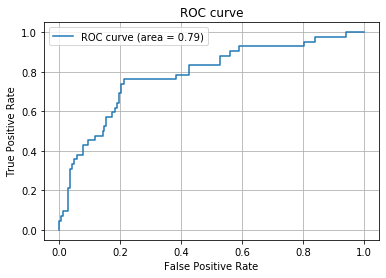

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7857142857142857



[I 2019-08-22 18:17:39,468] Finished trial#25 resulted in value: -0.7857142857142857. Current best value is -0.7872640180332489 with parameters: {'w_lda': 0.4, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:17:39,471] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:17:39,485] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:17:39,499] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:17:39,514] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


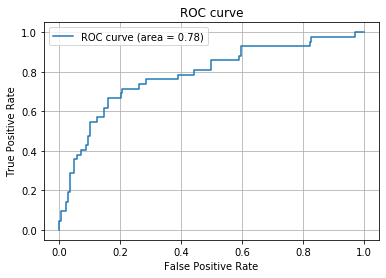

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7847280924204



[I 2019-08-22 18:18:12,803] Finished trial#26 resulted in value: -0.7847280924204. Current best value is -0.7872640180332489 with parameters: {'w_lda': 0.4, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:18:12,808] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:18:12,822] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:18:12,836] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:18:12,852] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


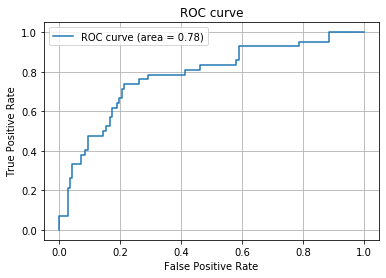

len: 211 , 211
confusion_matrix: 
[[150.  19.]
 [ 19.  23.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7807833192448577



[I 2019-08-22 18:18:46,693] Finished trial#27 resulted in value: -0.7807833192448577. Current best value is -0.7872640180332489 with parameters: {'w_lda': 0.4, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:18:46,697] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:18:46,712] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:18:46,727] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:18:46,743] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


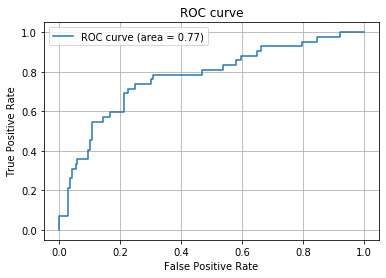

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.772189349112426



[I 2019-08-22 18:19:20,580] Finished trial#28 resulted in value: -0.772189349112426. Current best value is -0.7872640180332489 with parameters: {'w_lda': 0.4, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:19:20,584] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:19:20,599] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:19:20,614] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:19:20,630] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


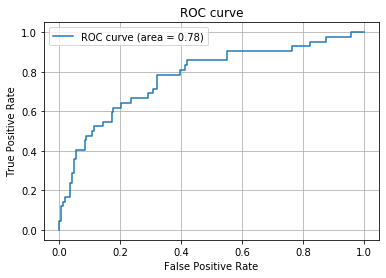

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7769794308255846



[I 2019-08-22 18:19:54,414] Finished trial#29 resulted in value: -0.7769794308255846. Current best value is -0.7872640180332489 with parameters: {'w_lda': 0.4, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:19:54,418] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:19:54,433] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:19:54,447] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:19:54,462] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


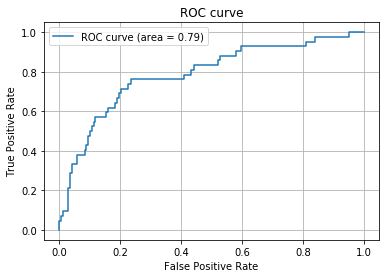

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7874049027895182



[I 2019-08-22 18:20:27,886] Finished trial#30 resulted in value: -0.7874049027895182. Current best value is -0.7874049027895182 with parameters: {'w_lda': 0.4, 'w_sv': 0.8, 'w_xgb': 0.8, 'w_lgbm': 0.30000000000000004}.
[W 2019-08-22 18:20:27,891] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:20:27,925] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:20:27,940] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:20:27,956] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


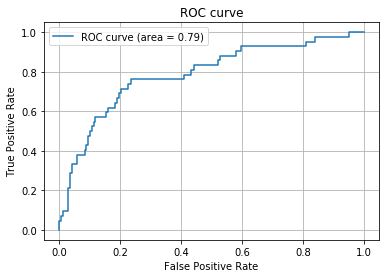

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7874049027895182



[I 2019-08-22 18:21:01,150] Finished trial#31 resulted in value: -0.7874049027895182. Current best value is -0.7874049027895182 with parameters: {'w_lda': 0.4, 'w_sv': 0.8, 'w_xgb': 0.8, 'w_lgbm': 0.30000000000000004}.
[W 2019-08-22 18:21:01,154] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:21:01,170] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:21:01,187] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:21:01,204] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


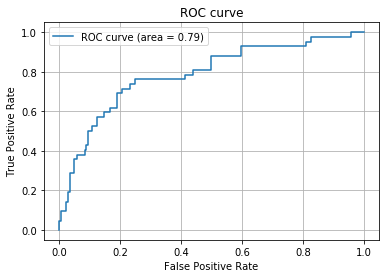

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7862778247393631



[I 2019-08-22 18:21:35,997] Finished trial#32 resulted in value: -0.7862778247393631. Current best value is -0.7874049027895182 with parameters: {'w_lda': 0.4, 'w_sv': 0.8, 'w_xgb': 0.8, 'w_lgbm': 0.30000000000000004}.
[W 2019-08-22 18:21:36,007] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:21:36,026] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:21:36,047] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:21:36,070] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


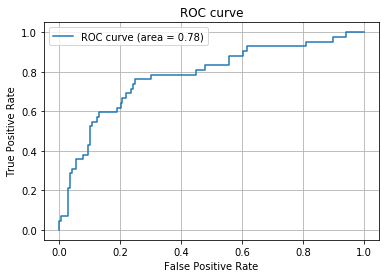

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7803606649760496



[I 2019-08-22 18:22:09,869] Finished trial#33 resulted in value: -0.7803606649760496. Current best value is -0.7874049027895182 with parameters: {'w_lda': 0.4, 'w_sv': 0.8, 'w_xgb': 0.8, 'w_lgbm': 0.30000000000000004}.
[W 2019-08-22 18:22:09,874] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:22:09,889] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:22:09,905] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:22:09,922] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


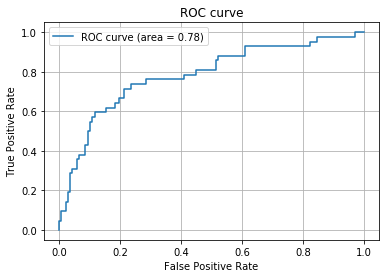

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.783178360101437



[I 2019-08-22 18:22:43,424] Finished trial#34 resulted in value: -0.783178360101437. Current best value is -0.7874049027895182 with parameters: {'w_lda': 0.4, 'w_sv': 0.8, 'w_xgb': 0.8, 'w_lgbm': 0.30000000000000004}.
[W 2019-08-22 18:22:43,428] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:22:43,443] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:22:43,459] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:22:43,476] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


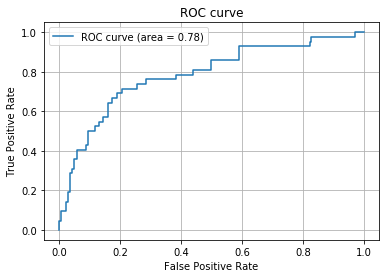

len: 211 , 211
confusion_matrix: 
[[148.  21.]
 [ 21.  21.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7838827838827839



[I 2019-08-22 18:23:16,856] Finished trial#35 resulted in value: -0.7838827838827839. Current best value is -0.7874049027895182 with parameters: {'w_lda': 0.4, 'w_sv': 0.8, 'w_xgb': 0.8, 'w_lgbm': 0.30000000000000004}.
[W 2019-08-22 18:23:16,861] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:23:16,878] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:23:16,896] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:23:16,913] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


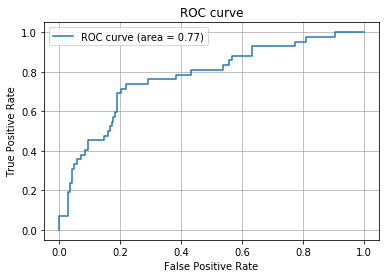

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7737390814313891



[I 2019-08-22 18:23:50,704] Finished trial#36 resulted in value: -0.7737390814313891. Current best value is -0.7874049027895182 with parameters: {'w_lda': 0.4, 'w_sv': 0.8, 'w_xgb': 0.8, 'w_lgbm': 0.30000000000000004}.
[W 2019-08-22 18:23:50,708] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:23:50,725] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:23:50,742] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:23:50,759] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


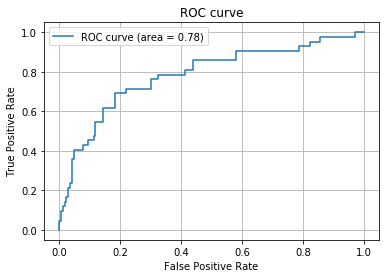

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7830374753451677



[I 2019-08-22 18:24:24,608] Finished trial#37 resulted in value: -0.7830374753451677. Current best value is -0.7874049027895182 with parameters: {'w_lda': 0.4, 'w_sv': 0.8, 'w_xgb': 0.8, 'w_lgbm': 0.30000000000000004}.
[W 2019-08-22 18:24:24,612] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:24:24,630] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:24:24,647] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:24:24,665] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


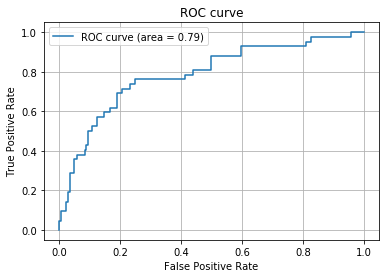

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7862778247393631



[I 2019-08-22 18:24:57,838] Finished trial#38 resulted in value: -0.7862778247393631. Current best value is -0.7874049027895182 with parameters: {'w_lda': 0.4, 'w_sv': 0.8, 'w_xgb': 0.8, 'w_lgbm': 0.30000000000000004}.
[W 2019-08-22 18:24:57,842] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:24:57,860] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:24:57,878] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:24:57,896] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


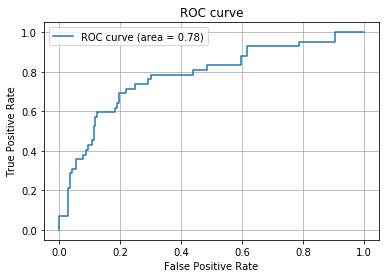

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.779374471682164



[I 2019-08-22 18:25:30,982] Finished trial#39 resulted in value: -0.779374471682164. Current best value is -0.7874049027895182 with parameters: {'w_lda': 0.4, 'w_sv': 0.8, 'w_xgb': 0.8, 'w_lgbm': 0.30000000000000004}.
[W 2019-08-22 18:25:30,986] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:25:31,004] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:25:31,022] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:25:31,041] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


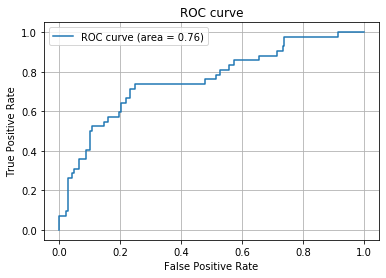

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7589461820231052



[I 2019-08-22 18:26:04,352] Finished trial#40 resulted in value: -0.7589461820231052. Current best value is -0.7874049027895182 with parameters: {'w_lda': 0.4, 'w_sv': 0.8, 'w_xgb': 0.8, 'w_lgbm': 0.30000000000000004}.
[W 2019-08-22 18:26:04,357] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:26:04,375] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:26:04,393] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:26:04,411] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


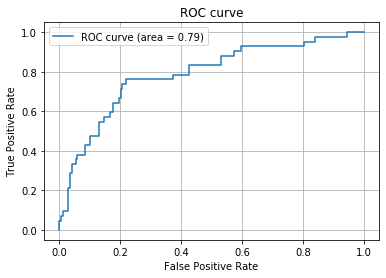

len: 211 , 211
confusion_matrix: 
[[150.  19.]
 [ 19.  23.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7864187094956326



[I 2019-08-22 18:26:37,448] Finished trial#41 resulted in value: -0.7864187094956326. Current best value is -0.7874049027895182 with parameters: {'w_lda': 0.4, 'w_sv': 0.8, 'w_xgb': 0.8, 'w_lgbm': 0.30000000000000004}.
[W 2019-08-22 18:26:37,452] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:26:37,470] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:26:37,488] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:26:37,506] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


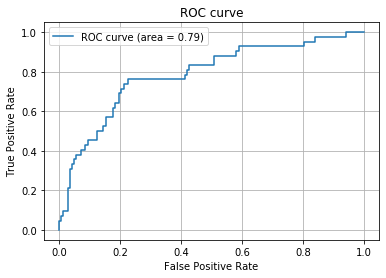

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7857142857142857



[I 2019-08-22 18:27:11,289] Finished trial#42 resulted in value: -0.7857142857142857. Current best value is -0.7874049027895182 with parameters: {'w_lda': 0.4, 'w_sv': 0.8, 'w_xgb': 0.8, 'w_lgbm': 0.30000000000000004}.
[W 2019-08-22 18:27:11,293] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:27:11,311] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:27:11,328] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:27:11,347] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


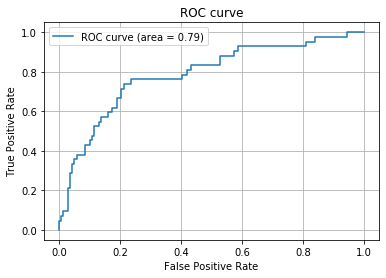

len: 211 , 211
confusion_matrix: 
[[150.  19.]
 [ 19.  23.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7868413637644407



[I 2019-08-22 18:27:45,658] Finished trial#43 resulted in value: -0.7868413637644407. Current best value is -0.7874049027895182 with parameters: {'w_lda': 0.4, 'w_sv': 0.8, 'w_xgb': 0.8, 'w_lgbm': 0.30000000000000004}.
[W 2019-08-22 18:27:45,662] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:27:45,682] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:27:45,701] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:27:45,720] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


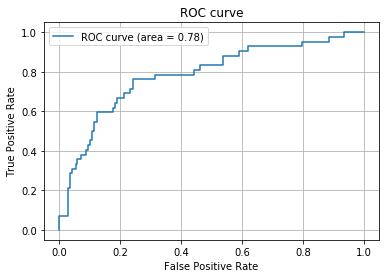

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7836010143702451



[I 2019-08-22 18:28:20,205] Finished trial#44 resulted in value: -0.7836010143702451. Current best value is -0.7874049027895182 with parameters: {'w_lda': 0.4, 'w_sv': 0.8, 'w_xgb': 0.8, 'w_lgbm': 0.30000000000000004}.
[W 2019-08-22 18:28:20,209] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:28:20,227] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:28:20,246] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:28:20,265] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


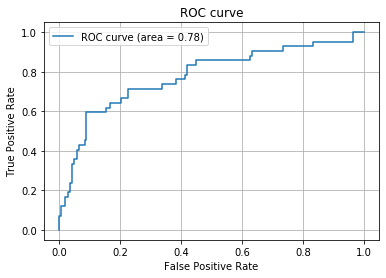

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7782473936320089



[I 2019-08-22 18:28:53,750] Finished trial#45 resulted in value: -0.7782473936320089. Current best value is -0.7874049027895182 with parameters: {'w_lda': 0.4, 'w_sv': 0.8, 'w_xgb': 0.8, 'w_lgbm': 0.30000000000000004}.
[W 2019-08-22 18:28:53,755] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:28:53,773] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:28:53,793] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:28:53,813] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


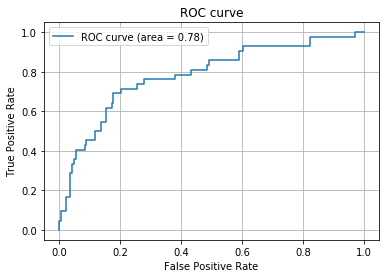

len: 211 , 211
confusion_matrix: 
[[148.  21.]
 [ 21.  21.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7836010143702452



[I 2019-08-22 18:29:27,791] Finished trial#46 resulted in value: -0.7836010143702452. Current best value is -0.7874049027895182 with parameters: {'w_lda': 0.4, 'w_sv': 0.8, 'w_xgb': 0.8, 'w_lgbm': 0.30000000000000004}.
[W 2019-08-22 18:29:27,795] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:29:27,815] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:29:27,834] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:29:27,854] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


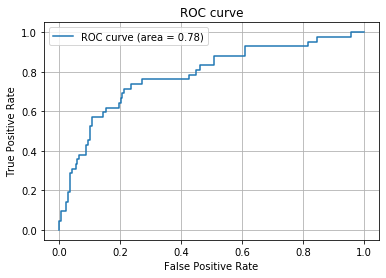

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7837418991265145



[I 2019-08-22 18:30:01,397] Finished trial#47 resulted in value: -0.7837418991265145. Current best value is -0.7874049027895182 with parameters: {'w_lda': 0.4, 'w_sv': 0.8, 'w_xgb': 0.8, 'w_lgbm': 0.30000000000000004}.
[W 2019-08-22 18:30:01,400] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:30:01,422] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:30:01,442] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:30:01,462] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


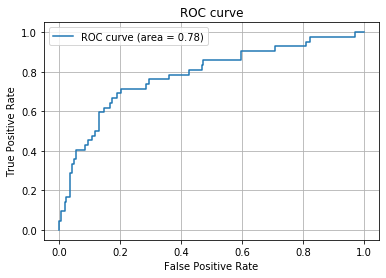

len: 211 , 211
confusion_matrix: 
[[148.  21.]
 [ 21.  21.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7833192448577064



[I 2019-08-22 18:30:34,947] Finished trial#48 resulted in value: -0.7833192448577064. Current best value is -0.7874049027895182 with parameters: {'w_lda': 0.4, 'w_sv': 0.8, 'w_xgb': 0.8, 'w_lgbm': 0.30000000000000004}.
[W 2019-08-22 18:30:34,951] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:30:34,971] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:30:34,991] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:30:35,011] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


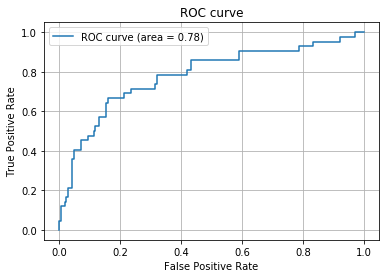

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7810650887573963



[I 2019-08-22 18:31:09,363] Finished trial#49 resulted in value: -0.7810650887573963. Current best value is -0.7874049027895182 with parameters: {'w_lda': 0.4, 'w_sv': 0.8, 'w_xgb': 0.8, 'w_lgbm': 0.30000000000000004}.
[W 2019-08-22 18:31:09,367] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:31:09,386] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:31:09,405] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:31:09,425] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


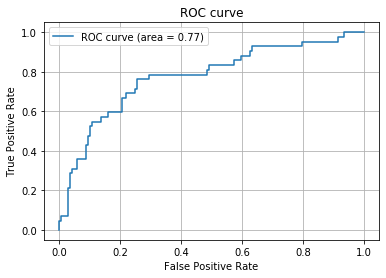

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7747252747252746



[I 2019-08-22 18:31:43,265] Finished trial#50 resulted in value: -0.7747252747252746. Current best value is -0.7874049027895182 with parameters: {'w_lda': 0.4, 'w_sv': 0.8, 'w_xgb': 0.8, 'w_lgbm': 0.30000000000000004}.
[W 2019-08-22 18:31:43,268] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:31:43,287] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:31:43,306] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:31:43,326] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


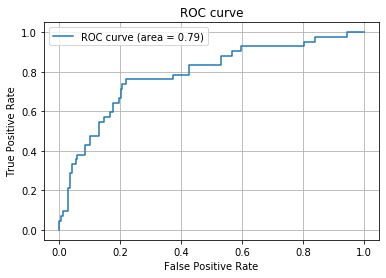

len: 211 , 211
confusion_matrix: 
[[150.  19.]
 [ 19.  23.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.786559594251902



[I 2019-08-22 18:32:17,337] Finished trial#51 resulted in value: -0.786559594251902. Current best value is -0.7874049027895182 with parameters: {'w_lda': 0.4, 'w_sv': 0.8, 'w_xgb': 0.8, 'w_lgbm': 0.30000000000000004}.
[W 2019-08-22 18:32:17,340] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:32:17,360] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:32:17,379] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:32:17,399] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


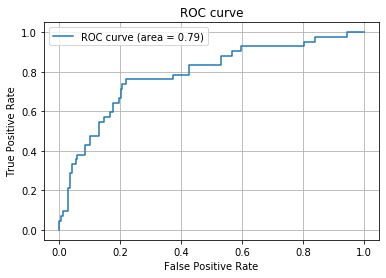

len: 211 , 211
confusion_matrix: 
[[150.  19.]
 [ 19.  23.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.786559594251902



[I 2019-08-22 18:32:52,019] Finished trial#52 resulted in value: -0.786559594251902. Current best value is -0.7874049027895182 with parameters: {'w_lda': 0.4, 'w_sv': 0.8, 'w_xgb': 0.8, 'w_lgbm': 0.30000000000000004}.
[W 2019-08-22 18:32:52,022] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:32:52,042] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:32:52,062] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:32:52,083] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


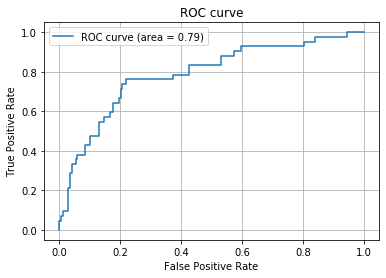

len: 211 , 211
confusion_matrix: 
[[150.  19.]
 [ 19.  23.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7864187094956326



[I 2019-08-22 18:33:26,430] Finished trial#53 resulted in value: -0.7864187094956326. Current best value is -0.7874049027895182 with parameters: {'w_lda': 0.4, 'w_sv': 0.8, 'w_xgb': 0.8, 'w_lgbm': 0.30000000000000004}.
[W 2019-08-22 18:33:26,434] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:33:26,455] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:33:26,476] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:33:26,497] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


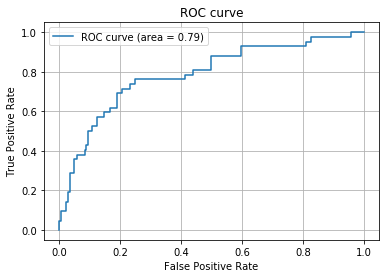

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7862778247393631



[I 2019-08-22 18:34:00,368] Finished trial#54 resulted in value: -0.7862778247393631. Current best value is -0.7874049027895182 with parameters: {'w_lda': 0.4, 'w_sv': 0.8, 'w_xgb': 0.8, 'w_lgbm': 0.30000000000000004}.
[W 2019-08-22 18:34:00,372] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:34:00,393] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:34:00,415] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:34:00,437] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


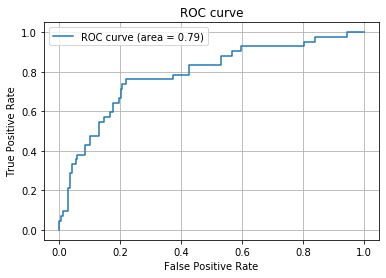

len: 211 , 211
confusion_matrix: 
[[150.  19.]
 [ 19.  23.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.786559594251902



[I 2019-08-22 18:34:34,043] Finished trial#55 resulted in value: -0.786559594251902. Current best value is -0.7874049027895182 with parameters: {'w_lda': 0.4, 'w_sv': 0.8, 'w_xgb': 0.8, 'w_lgbm': 0.30000000000000004}.
[W 2019-08-22 18:34:34,048] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:34:34,069] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:34:34,090] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:34:34,112] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


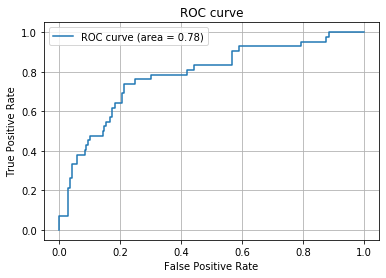

len: 211 , 211
confusion_matrix: 
[[150.  19.]
 [ 19.  23.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7833192448577063



[I 2019-08-22 18:35:07,743] Finished trial#56 resulted in value: -0.7833192448577063. Current best value is -0.7874049027895182 with parameters: {'w_lda': 0.4, 'w_sv': 0.8, 'w_xgb': 0.8, 'w_lgbm': 0.30000000000000004}.
[W 2019-08-22 18:35:07,748] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:35:07,769] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:35:07,791] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:35:07,813] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


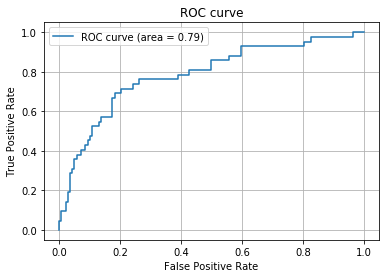

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7852916314454776



[I 2019-08-22 18:35:42,073] Finished trial#57 resulted in value: -0.7852916314454776. Current best value is -0.7874049027895182 with parameters: {'w_lda': 0.4, 'w_sv': 0.8, 'w_xgb': 0.8, 'w_lgbm': 0.30000000000000004}.
[W 2019-08-22 18:35:42,078] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:35:42,099] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:35:42,121] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:35:42,142] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


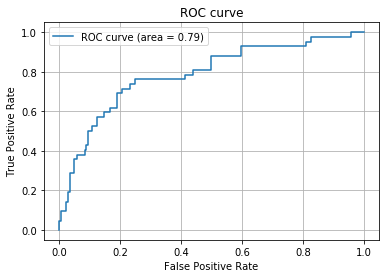

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7862778247393631



[I 2019-08-22 18:36:15,757] Finished trial#58 resulted in value: -0.7862778247393631. Current best value is -0.7874049027895182 with parameters: {'w_lda': 0.4, 'w_sv': 0.8, 'w_xgb': 0.8, 'w_lgbm': 0.30000000000000004}.
[W 2019-08-22 18:36:15,762] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:36:15,784] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:36:15,806] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:36:15,829] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


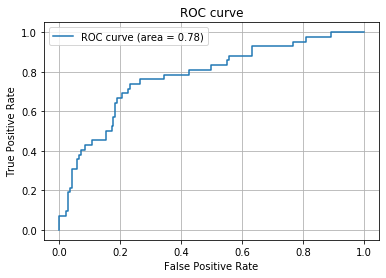

len: 211 , 211
confusion_matrix: 
[[150.  19.]
 [ 19.  23.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7761341222879684



[I 2019-08-22 18:36:49,964] Finished trial#59 resulted in value: -0.7761341222879684. Current best value is -0.7874049027895182 with parameters: {'w_lda': 0.4, 'w_sv': 0.8, 'w_xgb': 0.8, 'w_lgbm': 0.30000000000000004}.
[W 2019-08-22 18:36:49,968] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:36:49,989] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:36:50,011] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:36:50,033] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


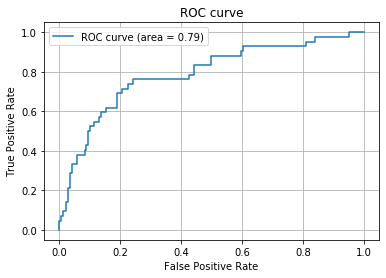

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7879684418145956



[I 2019-08-22 18:37:23,537] Finished trial#60 resulted in value: -0.7879684418145956. Current best value is -0.7879684418145956 with parameters: {'w_lda': 0.5, 'w_sv': 0.7000000000000001, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:37:23,542] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:37:23,564] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:37:23,586] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:37:23,608] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


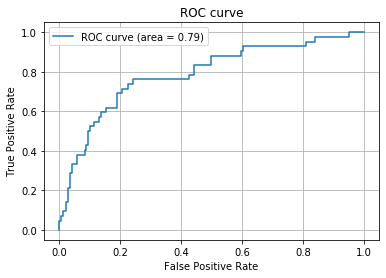

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7879684418145956



[I 2019-08-22 18:37:57,307] Finished trial#61 resulted in value: -0.7879684418145956. Current best value is -0.7879684418145956 with parameters: {'w_lda': 0.5, 'w_sv': 0.7000000000000001, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:37:57,311] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:37:57,334] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:37:57,357] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:37:57,381] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


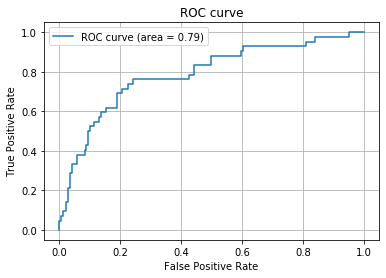

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7879684418145956



[I 2019-08-22 18:38:31,175] Finished trial#62 resulted in value: -0.7879684418145956. Current best value is -0.7879684418145956 with parameters: {'w_lda': 0.5, 'w_sv': 0.7000000000000001, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:38:31,179] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:38:31,201] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:38:31,224] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:38:31,248] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


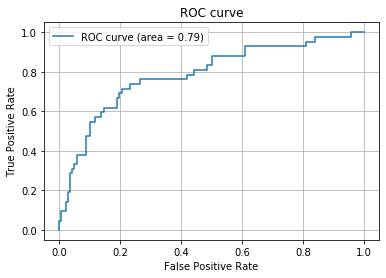

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7859960552268244



[I 2019-08-22 18:39:05,250] Finished trial#63 resulted in value: -0.7859960552268244. Current best value is -0.7879684418145956 with parameters: {'w_lda': 0.5, 'w_sv': 0.7000000000000001, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:39:05,255] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:39:05,278] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:39:05,302] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:39:05,326] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


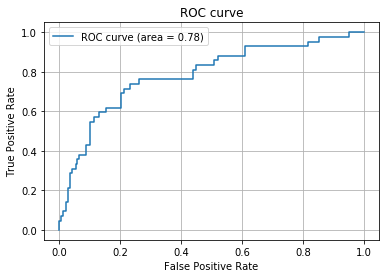

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7843054381515921



[I 2019-08-22 18:39:38,838] Finished trial#64 resulted in value: -0.7843054381515921. Current best value is -0.7879684418145956 with parameters: {'w_lda': 0.5, 'w_sv': 0.7000000000000001, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:39:38,842] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:39:38,864] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:39:38,886] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:39:38,909] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


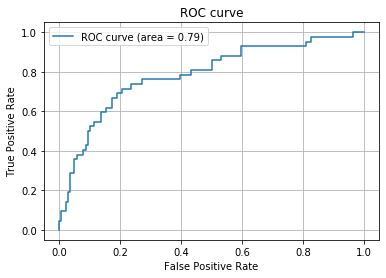

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7865595942519019



[I 2019-08-22 18:40:12,378] Finished trial#65 resulted in value: -0.7865595942519019. Current best value is -0.7879684418145956 with parameters: {'w_lda': 0.5, 'w_sv': 0.7000000000000001, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:40:12,382] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:40:12,406] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:40:12,430] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:40:12,454] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


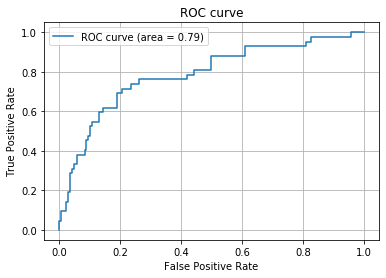

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7862778247393633



[I 2019-08-22 18:40:46,058] Finished trial#66 resulted in value: -0.7862778247393633. Current best value is -0.7879684418145956 with parameters: {'w_lda': 0.5, 'w_sv': 0.7000000000000001, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:40:46,062] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:40:46,086] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:40:46,108] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:40:46,133] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


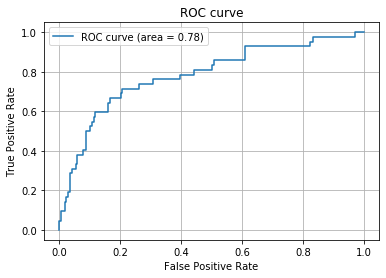

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7834601296139757



[I 2019-08-22 18:41:20,490] Finished trial#67 resulted in value: -0.7834601296139757. Current best value is -0.7879684418145956 with parameters: {'w_lda': 0.5, 'w_sv': 0.7000000000000001, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:41:20,495] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:41:20,519] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:41:20,543] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:41:20,568] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


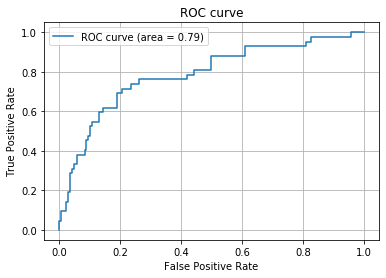

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7862778247393633



[I 2019-08-22 18:41:54,636] Finished trial#68 resulted in value: -0.7862778247393633. Current best value is -0.7879684418145956 with parameters: {'w_lda': 0.5, 'w_sv': 0.7000000000000001, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:41:54,640] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:41:54,671] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:41:54,715] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:41:54,751] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


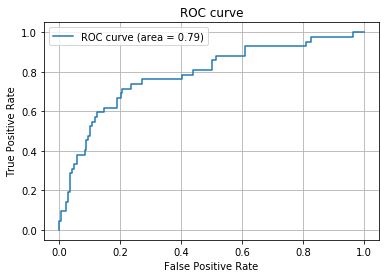

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7857142857142858



[I 2019-08-22 18:42:28,565] Finished trial#69 resulted in value: -0.7857142857142858. Current best value is -0.7879684418145956 with parameters: {'w_lda': 0.5, 'w_sv': 0.7000000000000001, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:42:28,569] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:42:28,594] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:42:28,619] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:42:28,644] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


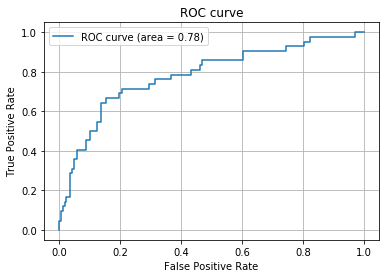

len: 211 , 211
confusion_matrix: 
[[148.  21.]
 [ 21.  21.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7830374753451677



[I 2019-08-22 18:43:02,322] Finished trial#70 resulted in value: -0.7830374753451677. Current best value is -0.7879684418145956 with parameters: {'w_lda': 0.5, 'w_sv': 0.7000000000000001, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:43:02,326] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:43:02,350] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:43:02,374] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:43:02,399] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


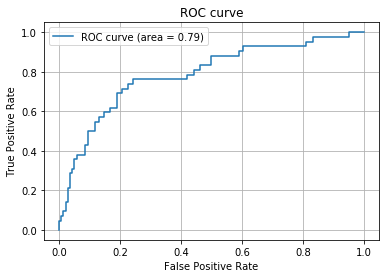

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7871231332769795



[I 2019-08-22 18:43:36,388] Finished trial#71 resulted in value: -0.7871231332769795. Current best value is -0.7879684418145956 with parameters: {'w_lda': 0.5, 'w_sv': 0.7000000000000001, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:43:36,391] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:43:36,417] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:43:36,442] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:43:36,467] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


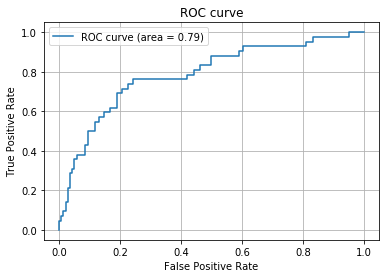

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7871231332769795



[I 2019-08-22 18:44:10,506] Finished trial#72 resulted in value: -0.7871231332769795. Current best value is -0.7879684418145956 with parameters: {'w_lda': 0.5, 'w_sv': 0.7000000000000001, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:44:10,515] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:44:10,545] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:44:10,570] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:44:10,596] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


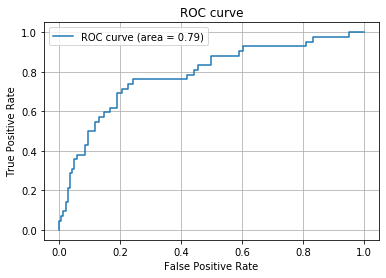

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7872640180332489



[I 2019-08-22 18:44:44,186] Finished trial#73 resulted in value: -0.7872640180332489. Current best value is -0.7879684418145956 with parameters: {'w_lda': 0.5, 'w_sv': 0.7000000000000001, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:44:44,190] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:44:44,216] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:44:44,242] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:44:44,268] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


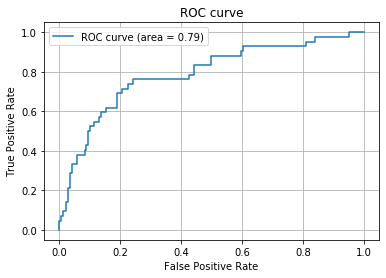

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7879684418145956



[I 2019-08-22 18:45:17,800] Finished trial#74 resulted in value: -0.7879684418145956. Current best value is -0.7879684418145956 with parameters: {'w_lda': 0.5, 'w_sv': 0.7000000000000001, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:45:17,804] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:45:17,829] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:45:17,854] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:45:17,879] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


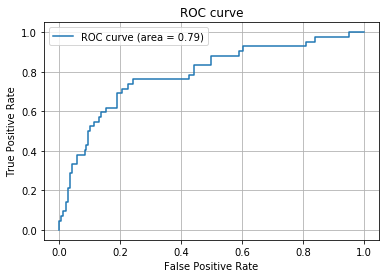

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.788109326570865



[I 2019-08-22 18:45:53,138] Finished trial#75 resulted in value: -0.788109326570865. Current best value is -0.788109326570865 with parameters: {'w_lda': 0.5, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:45:53,143] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:45:53,168] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:45:53,193] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:45:53,218] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


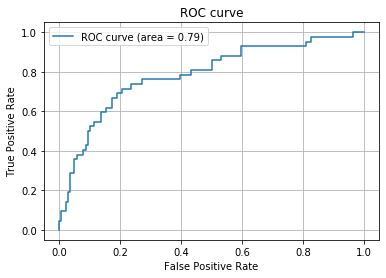

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7865595942519019



[I 2019-08-22 18:46:27,769] Finished trial#76 resulted in value: -0.7865595942519019. Current best value is -0.788109326570865 with parameters: {'w_lda': 0.5, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:46:27,773] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:46:27,799] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:46:27,825] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:46:27,853] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


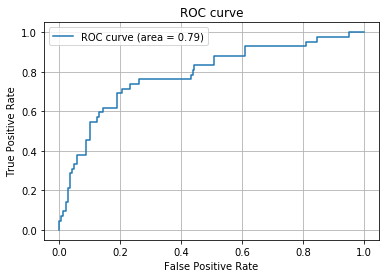

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7867004790081713



[I 2019-08-22 18:47:02,164] Finished trial#77 resulted in value: -0.7867004790081713. Current best value is -0.788109326570865 with parameters: {'w_lda': 0.5, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:47:02,169] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:47:02,195] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:47:02,223] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:47:02,253] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


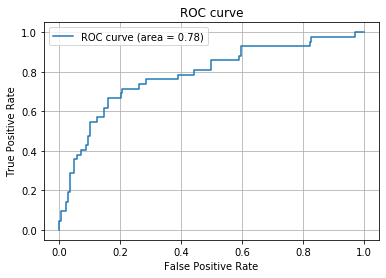

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7847280924204



[I 2019-08-22 18:47:35,834] Finished trial#78 resulted in value: -0.7847280924204. Current best value is -0.788109326570865 with parameters: {'w_lda': 0.5, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:47:35,839] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:47:35,866] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:47:35,894] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:47:35,922] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


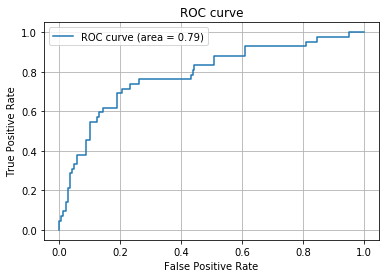

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7867004790081713



[I 2019-08-22 18:48:09,509] Finished trial#79 resulted in value: -0.7867004790081713. Current best value is -0.788109326570865 with parameters: {'w_lda': 0.5, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:48:09,513] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:48:09,540] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:48:09,570] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:48:09,618] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


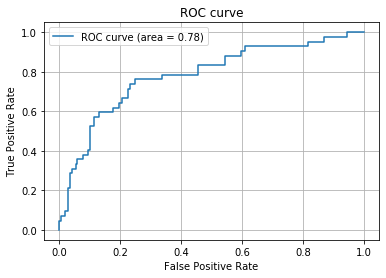

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7821921668075514



[I 2019-08-22 18:48:43,235] Finished trial#80 resulted in value: -0.7821921668075514. Current best value is -0.788109326570865 with parameters: {'w_lda': 0.5, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:48:43,244] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:48:43,271] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:48:43,298] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:48:43,327] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


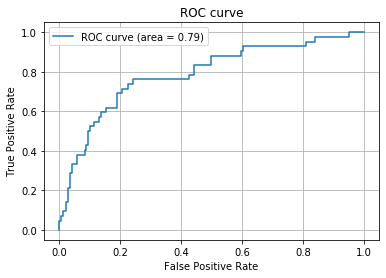

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7879684418145956



[I 2019-08-22 18:49:17,194] Finished trial#81 resulted in value: -0.7879684418145956. Current best value is -0.788109326570865 with parameters: {'w_lda': 0.5, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:49:17,198] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:49:17,225] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:49:17,252] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:49:17,279] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


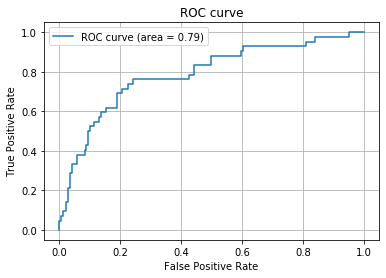

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7879684418145956



[I 2019-08-22 18:49:51,445] Finished trial#82 resulted in value: -0.7879684418145956. Current best value is -0.788109326570865 with parameters: {'w_lda': 0.5, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:49:51,449] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:49:51,476] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:49:51,505] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:49:51,535] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


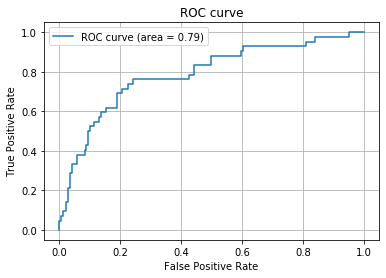

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7879684418145956



[I 2019-08-22 18:50:25,913] Finished trial#83 resulted in value: -0.7879684418145956. Current best value is -0.788109326570865 with parameters: {'w_lda': 0.5, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:50:25,917] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:50:25,945] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:50:25,972] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:50:26,003] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


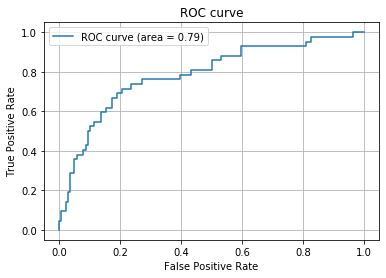

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7865595942519019



[I 2019-08-22 18:51:00,482] Finished trial#84 resulted in value: -0.7865595942519019. Current best value is -0.788109326570865 with parameters: {'w_lda': 0.5, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:51:00,487] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:51:00,515] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:51:00,544] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:51:00,576] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


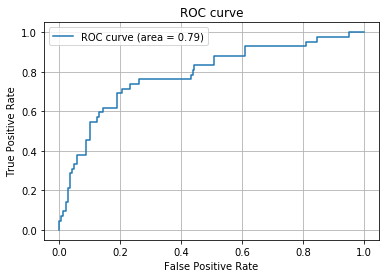

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7867004790081713



[I 2019-08-22 18:51:34,541] Finished trial#85 resulted in value: -0.7867004790081713. Current best value is -0.788109326570865 with parameters: {'w_lda': 0.5, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:51:34,546] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:51:34,574] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:51:34,602] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:51:34,633] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


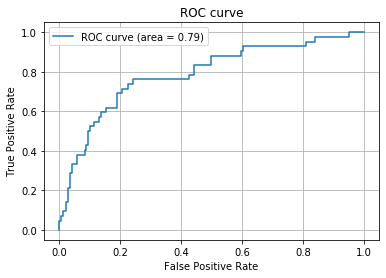

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7879684418145956



[I 2019-08-22 18:52:08,085] Finished trial#86 resulted in value: -0.7879684418145956. Current best value is -0.788109326570865 with parameters: {'w_lda': 0.5, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:52:08,089] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:52:08,118] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:52:08,147] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:52:08,177] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


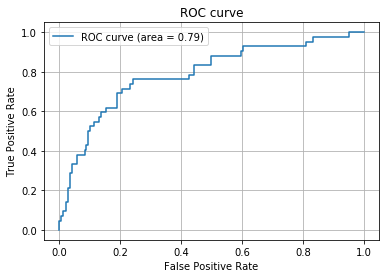

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7879684418145956



[I 2019-08-22 18:52:41,940] Finished trial#87 resulted in value: -0.7879684418145956. Current best value is -0.788109326570865 with parameters: {'w_lda': 0.5, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:52:41,944] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:52:41,973] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:52:42,001] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:52:42,031] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


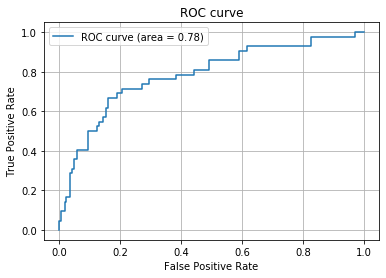

len: 211 , 211
confusion_matrix: 
[[148.  21.]
 [ 21.  21.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7831783601014369



[I 2019-08-22 18:53:15,913] Finished trial#88 resulted in value: -0.7831783601014369. Current best value is -0.788109326570865 with parameters: {'w_lda': 0.5, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:53:15,917] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:53:15,946] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:53:15,975] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:53:16,005] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


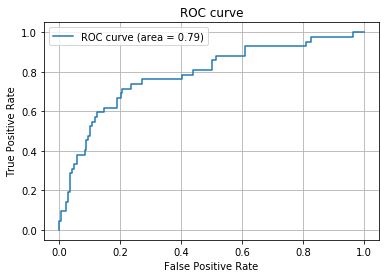

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7857142857142858



[I 2019-08-22 18:53:49,908] Finished trial#89 resulted in value: -0.7857142857142858. Current best value is -0.788109326570865 with parameters: {'w_lda': 0.5, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:53:49,912] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:53:49,942] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:53:49,972] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:53:50,004] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


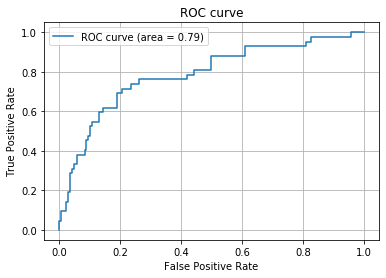

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7862778247393633



[I 2019-08-22 18:54:24,300] Finished trial#90 resulted in value: -0.7862778247393633. Current best value is -0.788109326570865 with parameters: {'w_lda': 0.5, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:54:24,304] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:54:24,334] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:54:24,365] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:54:24,395] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


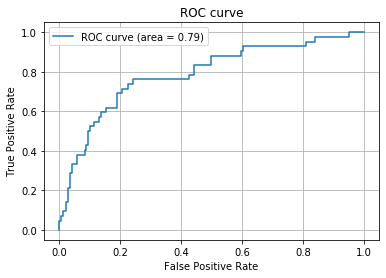

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7879684418145956



[I 2019-08-22 18:54:58,073] Finished trial#91 resulted in value: -0.7879684418145956. Current best value is -0.788109326570865 with parameters: {'w_lda': 0.5, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:54:58,076] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:54:58,105] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:54:58,134] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:54:58,165] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


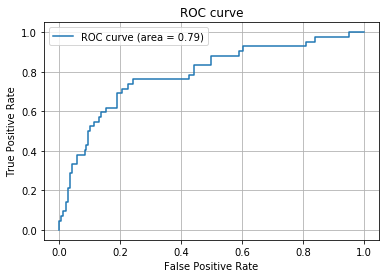

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.788109326570865



[I 2019-08-22 18:55:32,020] Finished trial#92 resulted in value: -0.788109326570865. Current best value is -0.788109326570865 with parameters: {'w_lda': 0.5, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:55:32,024] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:55:32,054] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:55:32,083] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:55:32,114] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


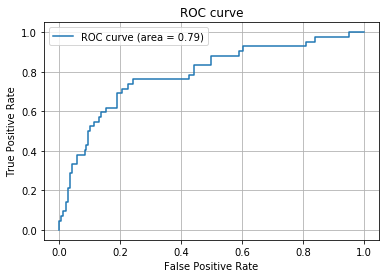

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.788109326570865



[I 2019-08-22 18:56:06,661] Finished trial#93 resulted in value: -0.788109326570865. Current best value is -0.788109326570865 with parameters: {'w_lda': 0.5, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:56:06,665] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:56:06,695] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:56:06,724] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:56:06,755] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


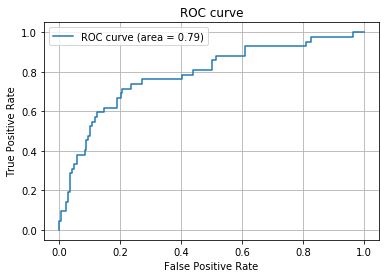

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7857142857142858



[I 2019-08-22 18:56:40,227] Finished trial#94 resulted in value: -0.7857142857142858. Current best value is -0.788109326570865 with parameters: {'w_lda': 0.5, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:56:40,237] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:56:40,271] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:56:40,302] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:56:40,335] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


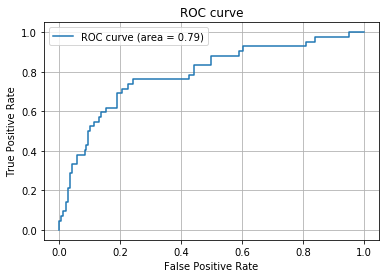

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.788109326570865



[I 2019-08-22 18:57:14,289] Finished trial#95 resulted in value: -0.788109326570865. Current best value is -0.788109326570865 with parameters: {'w_lda': 0.5, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:57:14,292] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:57:14,322] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:57:14,353] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:57:14,386] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


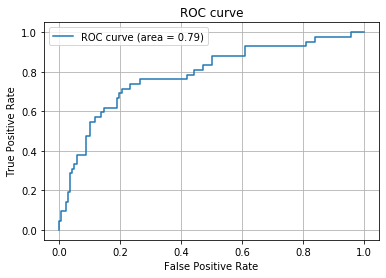

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7862778247393631



[I 2019-08-22 18:57:48,219] Finished trial#96 resulted in value: -0.7862778247393631. Current best value is -0.788109326570865 with parameters: {'w_lda': 0.5, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:57:48,223] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:57:48,254] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:57:48,285] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:57:48,318] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


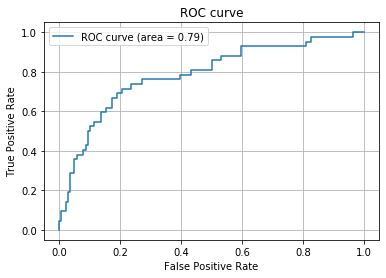

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7865595942519019



[I 2019-08-22 18:58:22,084] Finished trial#97 resulted in value: -0.7865595942519019. Current best value is -0.788109326570865 with parameters: {'w_lda': 0.5, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:58:22,089] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:58:22,119] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:58:22,150] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:58:22,184] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


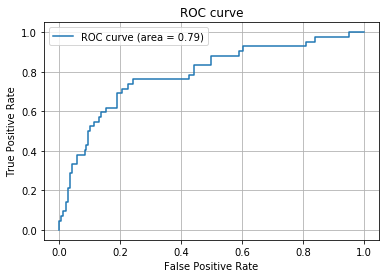

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.788109326570865



[I 2019-08-22 18:58:55,941] Finished trial#98 resulted in value: -0.788109326570865. Current best value is -0.788109326570865 with parameters: {'w_lda': 0.5, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.
[W 2019-08-22 18:58:55,945] The range of parameter `w_lda` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:58:55,976] The range of parameter `w_sv` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:58:56,007] The range of parameter `w_xgb` is not divisible by `q`, and is replaced by [0, 0.9].
[W 2019-08-22 18:58:56,040] The range of parameter `w_lgbm` is not divisible by `q`, and is replaced by [0, 0.9].


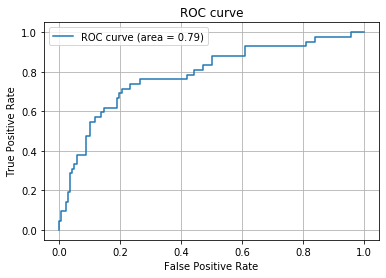

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7862778247393631



[I 2019-08-22 18:59:29,883] Finished trial#99 resulted in value: -0.7862778247393631. Current best value is -0.788109326570865 with parameters: {'w_lda': 0.5, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.


FrozenTrial(number=75, state=<TrialState.COMPLETE: 1>, value=-0.788109326570865, datetime_start=datetime.datetime(2019, 8, 22, 18, 45, 17, 803856), datetime_complete=datetime.datetime(2019, 8, 22, 18, 45, 53, 116249), params={'w_lda': 0.5, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}, distributions={'w_lda': DiscreteUniformDistribution(low=0, high=0.9, q=0.1), 'w_sv': DiscreteUniformDistribution(low=0, high=0.9, q=0.1), 'w_xgb': DiscreteUniformDistribution(low=0, high=0.9, q=0.1), 'w_lgbm': DiscreteUniformDistribution(low=0, high=0.9, q=0.1)}, user_attrs={}, system_attrs={'_number': 75}, intermediate_values={}, params_in_internal_repr={'w_lda': 0.5, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}, trial_id=75)


In [45]:
main()

In [ ]:
# best value is -0.7874049027895181 
# with parameters: {'w_lr': 0.1, 'w_lda': 0.30000000000000004, 'w_sv': 0.9, 'w_xgb': 0.8, 'w_lgbm': 0.4}.

# without lr
# Current best value is -0.788109326570865 with parameters: {'w_lda': 0.5, 'w_sv': 0.9, 'w_xgb': 0.9, 'w_lgbm': 0.4}.